In [6]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import defaultdict
from tensorflow.keras.utils import plot_model


2.1.0


In [3]:
#just a continuous 1-line epoch print
class create_accuracy_callback(tf.keras.callbacks.Callback):
    '''
    Callback function to stop training at 100% accuracy
    '''
    def on_epoch_end(self, epoch, logs={}):
        #one line print of the epoch, training accuracy, and validation accuracy
      
        if epoch != 0 and epoch % 5 == 0:
            print("\repoch: %d, train_acc: %1.4f, val_acc: %1.4f" % (epoch,logs['accuracy'],logs['val_accuracy']),end="")


In [7]:
from tensorflow.keras.constraints import MinMaxNorm

def build_instance_model(H=200,rate=0.25,n_features=38):

    model = tf.keras.Sequential([
        BatchNormalization(input_shape=(2,19)),              
        Dropout(rate),
        LSTM(n_features,return_sequences=True),
        Dropout(rate*2),
        TimeDistributed(Dense(n_features,activation="relu")),
        Flatten(),
        Dropout(rate),
        Dense(2, activation="sigmoid")
    ])

    return model


def build_model(H=50,n_features=38,n_steps=10,rate=0.25):
    model = tf.keras.Sequential([
                                 
        tf.keras.layers.GaussianNoise(0.0001,dtype="float32",input_shape=(n_steps,n_features)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features,activation="relu")),
        tf.keras.layers.LSTM(H,input_shape=(n_steps,n_features)),
        tf.keras.layers.Dense(H,activation="relu"),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(1,activation='relu')
    ])
    

    return model



model = build_instance_model()
model.summary()
plot_model(model,show_shapes=True,to_file="./inst.png")


model = build_model()
model.summary()
plot_model(model,show_shapes=True,to_file="./lstm.png")


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 2, 19)             76        
_________________________________________________________________
dropout_3 (Dropout)          (None, 2, 19)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2, 38)             8816      
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 38)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 38)             1482      
_________________________________________________________________
flatten_1 (Flatten)          (None, 76)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 76)               

In [8]:
from tensorflow.keras.optimizers.schedules import InverseTimeDecay, ExponentialDecay
from tensorflow.keras.utils import plot_model
import os

BATCH = 1000
MAX_EPOCHS = 5000
check_accuracy = create_accuracy_callback()

def train_model(model,data_train,data_test,lr=1e-2,momentum=0.9,clipnorm=0.5,fname="model"):

    lr_schedule = InverseTimeDecay(lr,
                                   decay_steps=10*100,
                                   decay_rate=0.8,
                                   staircase=False)



    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adadelta(0.25),
                  metrics=['accuracy'])

    
    history = model.fit(data_train,
              epochs=MAX_EPOCHS,
              validation_data=data_test,
              callbacks=[check_accuracy],
              verbose=0)
    

    

In [ ]:

#this uses various slices of data gathered from my nhlData processing file
#it will not work without first running it and generating some files
f = [["cumulative"],["travel"],["travel-cumulative"],["travel-league_percentile"],["travel-game"],["league_percentile"],["game"],["team_percentile"],]

datas = defaultdict(lambda: {})
for fileset in f:
    with open("./X_%s_N5.pkl" % fileset[0],'rb') as f:
        X = pickle.load(f)
        
    if 19652 not in X.shape:
      X = np.swapaxes(X,0,1)
      X = np.swapaxes(X,0,2)
    print(X.shape)
    
    with open("./y_%s_N5.pkl" % fileset[0],'rb') as f:
        y = pickle.load(f)
    print(y.shape)
    print()

    datas[fileset[0]]= (X,y)



In [ ]:
import json

accs = {}
accs["hidden_units"] = []
accs["accuracy"] = []
accs["lr"] = []
accs["features"] = []

Hs = [200,100,50]
LR = [0.1,0.01]
H = 100
for features in datas:
    print(features)
    X,y = datas[features]

    # fname = "H"+str(H)+"_N10_" + "t"
    for rep in range(2):
        if len(y.shape) > 1:
        y = y[:,:1]
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, shuffle=True)
        X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.2, shuffle=True)


        train_dataset = tf.data.Dataset.from_tensor_slices((np.array(X_train), y_train))
        train_dataset = train_dataset.batch(BATCH)
        valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid,y_valid))
        valid_dataset = valid_dataset.batch(BATCH)

        test_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
        test_dataset = test_dataset.batch(BATCH)

        model = build_model(H=100,n_steps=X_train.shape[1],n_features=X_test.shape[2])
        train_model(model,train_dataset,valid_dataset,lr=0.01)

        test_acc = model.evaluate(test_dataset)[-1]
        accs["accuracy"].append(test_acc)
        accs["features"].append(features)




with open("./valid_acc_features.json","w") as f:
    json.dump(accs,f)


 


In [0]:
print([(i,len(accs[i])) for i in accs])

[('hidden_units', 0), ('accuracy', 16), ('lr', 0), ('features', 16)]


In [0]:
accs = {"features":accs["features"],"accuracy":accs["accuracy"]}
accs = pd.DataFrame(accs)

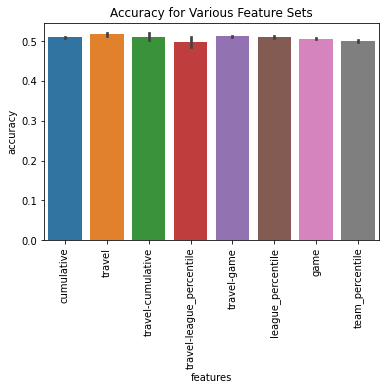

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x="features",y="accuracy",data=accs)
plt.title("Accuracy for Various Feature Sets")
plt.xticks(rotation=90)
plt.savefig("fig2.png")
plt.show()